# Transport following a breaking event - Example Test on Mission 19 

In [101]:
import cftime
from datetime import timedelta
from datetime import datetime
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy import signal

import mission_tools

%matplotlib widget

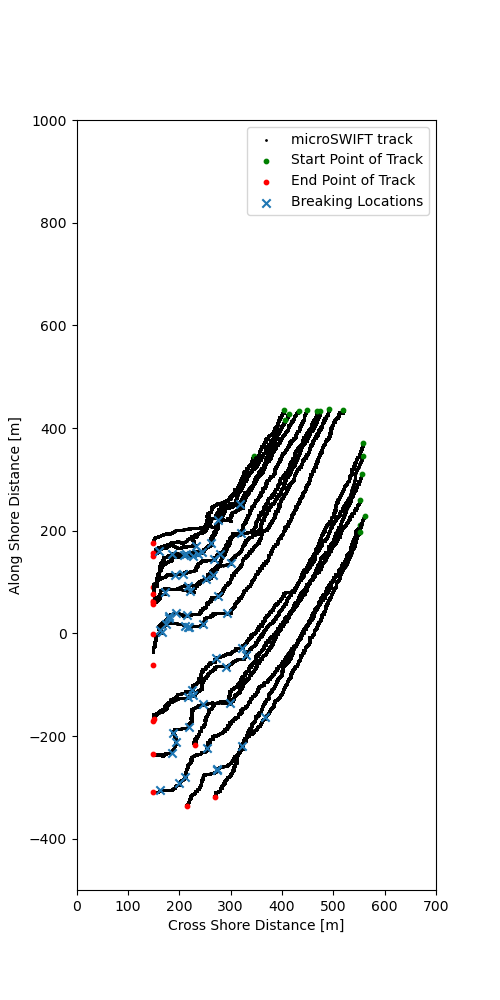

In [97]:
# Load mission 19 data and plot tracks over the radar image
mission_nc_path = '../microSWIFT_data/final_dataset/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Load the breaker dataset
breaker_df = pd.read_csv('../microSWIFT_data/breaker_df.csv')
breaker_df_mission19 = breaker_df[breaker_df['mission number'] == 19]

# Plot the microSWIFT tracks over the radar image
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])
vertical_accel = np.ma.masked_invalid(mission_dataset['acceleration_z_body'])
velocity_ew = np.ma.masked_invalid(mission_dataset['velocity_ew'])
time_vals = mission_dataset['time'][:]

fig, ax = plt.subplots(figsize=(5,10))

for n in range(mission_dataset['trajectory'].size-1):
    edge_inds_x = np.ma.flatnotmasked_edges(x_locations[n,:])
    edge_inds_y = np.ma.flatnotmasked_edges(y_locations[n,:])
    start_ind = np.max([edge_inds_x[0], edge_inds_y[0]])
    end_ind = np.min([edge_inds_x[1], edge_inds_y[1]])
    map = ax.scatter(x_locations[n,:],
                        y_locations[n,:],
                        c='k', s=1)
    map = ax.scatter(x_locations[n,start_ind],
                     y_locations[n,start_ind],
                     c='g', s=10)
    map = ax.scatter(x_locations[n,end_ind],
                     y_locations[n,end_ind],
                     c='r', s=10)
    
# plot last track and label points for legend
edge_inds_x = np.ma.flatnotmasked_edges(x_locations[-1,:])
edge_inds_y = np.ma.flatnotmasked_edges(y_locations[-1,:])
start_ind = np.max([edge_inds_x[0], edge_inds_y[0]])
end_ind = np.min([edge_inds_x[1], edge_inds_y[1]])
map = ax.scatter(x_locations[-1,:],
                    y_locations[-1,:],
                    c='k', s=1, label='microSWIFT track')
map = ax.scatter(x_locations[-1,start_ind],
                    y_locations[-1,start_ind],
                    c='g', s=10, label='Start Point of Track')
map = ax.scatter(x_locations[-1,end_ind],
                    y_locations[-1,end_ind],
                    c='r', s=10, label='End Point of Track')

# Scatter all Detected Breaking locations from the mission
ax.scatter(breaker_df_mission19['cross shore location [m]'], breaker_df_mission19['along shore location [m]'], 
           marker='x', label='Breaking Locations')

ax.set_xlim(0, 700)
ax.set_ylim(-500, 1000)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Along Shore Distance [m]')
ax.legend()
ax.set_aspect('equal')

In [3]:
# Pick an example trajectory and look how many breaking events it has
trajectory_num = 5
example_trajectory_df = breaker_df_mission19[breaker_df_mission19['trajectory number'] == trajectory_num]
example_trajectory_df

,Unnamed: 0,time,mission number,trajectory number,cross shore location [m],cross shore location normalized [m],along shore location [m]
275,275,2021-10-08 18:39:57.453064,19.0,5.0,299.766668,1.096839,-136.435820
276,276,2021-10-08 18:40:42.452884,19.0,5.0,246.941383,0.903552,-138.494211
277,277,2021-10-08 18:42:37.452424,19.0,5.0,218.379551,0.799045,-182.966953
278,278,2021-10-08 18:43:07.452304,19.0,5.0,188.175814,0.688531,-193.960200
279,279,2021-10-08 18:43:47.452144,19.0,5.0,192.975585,0.706093,-212.393027
280,280,2021-10-08 18:44:22.452004,19.0,5.0,185.562165,0.678967,-233.452504


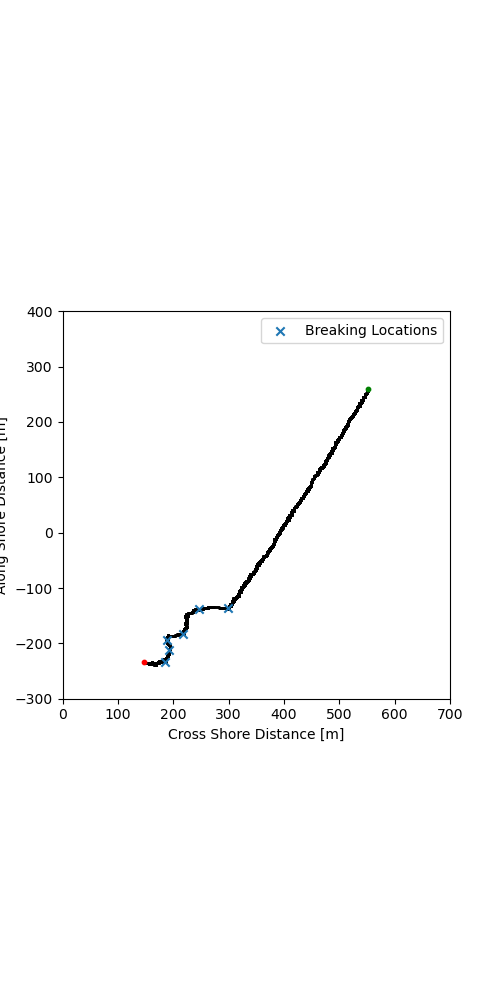

In [4]:
# Plot the single trajectory
fig, ax = plt.subplots(figsize=(5,10))

edge_inds_x = np.ma.flatnotmasked_edges(x_locations[trajectory_num,:])
edge_inds_y = np.ma.flatnotmasked_edges(y_locations[trajectory_num,:])
start_ind = np.max([edge_inds_x[0], edge_inds_y[0]])
end_ind = np.min([edge_inds_x[1], edge_inds_y[1]])
map = ax.scatter(x_locations[trajectory_num,:],
                    y_locations[trajectory_num,:],
                    c='k', s=1)
map = ax.scatter(x_locations[trajectory_num,start_ind],
                    y_locations[trajectory_num,start_ind],
                    c='g', s=10)
map = ax.scatter(x_locations[trajectory_num,end_ind],
                    y_locations[trajectory_num,end_ind],
                    c='r', s=10)

# Scatter all Detected Breaking locations from the mission
ax.scatter(example_trajectory_df['cross shore location [m]'], example_trajectory_df['along shore location [m]'], 
           marker='x', label='Breaking Locations')

ax.set_xlim(0, 700)
ax.set_ylim(-300, 400)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Along Shore Distance [m]')
ax.legend()
ax.set_aspect('equal')

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/2260302307.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])


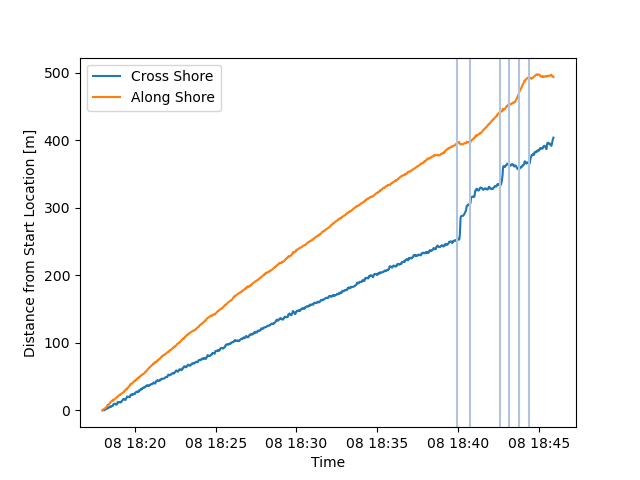

In [5]:
# Plot the time series of cross shore and along shore location with the breaking events
time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)

# Convert times to actual datetimes
example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
breaking_event_times = example_trajectory_df['time'].tolist()

fig, ax = plt.subplots()
ax.plot(time, x_locations[trajectory_num,0] - x_locations[trajectory_num,:], label='Cross Shore')
ax.plot(time, y_locations[trajectory_num,0] - y_locations[trajectory_num,:], label='Along Shore')
for n in range(len(breaking_event_times)):
    ax.axvline(breaking_event_times[n], color='lightsteelblue')
ax.set_xlabel('Time')
ax.set_ylabel('Distance from Start Location [m]')
ax.legend()

In [6]:
# Create a pandas dataframe from the cross and along shore location and time variables
trajectory_df = pd.DataFrame(np.transpose(np.array([time, x_locations[trajectory_num,:], y_locations[trajectory_num,:]])), columns=['time', 'cross shore location', 'along shore location'])
trajectory_df

,time,cross shore location,along shore location
0,2021-10-08 18:18:00.000000,552.201602,259.523742
1,2021-10-08 18:18:00.083333,552.201602,259.523742
2,2021-10-08 18:18:00.166666,552.201602,259.523742
3,2021-10-08 18:18:00.249999,552.201602,259.523742
4,2021-10-08 18:18:00.333332,552.181468,259.465269
...,...,...,...
20156,2021-10-08 18:45:59.659948,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0
20157,2021-10-08 18:45:59.743281,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0
20158,2021-10-08 18:45:59.826614,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0
20159,2021-10-08 18:45:59.909947,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0


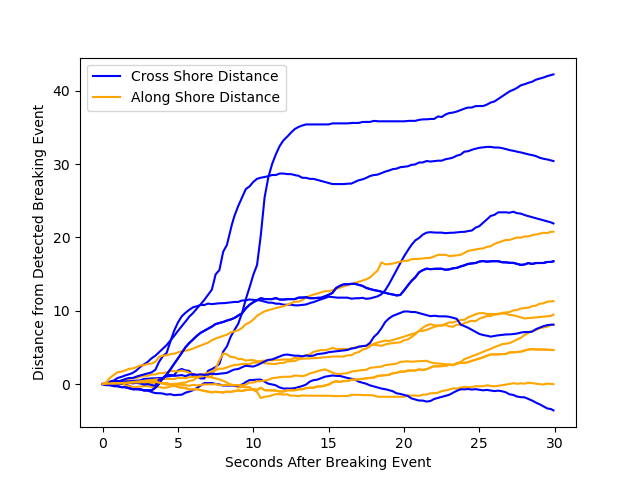

In [7]:
# Plot trajectories following a breaking event (30 seconds after event)
fig, ax = plt.subplots()
ax.set_xlabel('Seconds After Breaking Event')
ax.set_ylabel('Distance from Detected Breaking Event')

# Save profiles after breaking event
cross_shore_dist_after_breaking = []
along_shore_dist_after_breaking = []

for n in range(len(breaking_event_times)):  
    after_breaking_event_df = trajectory_df[trajectory_df.time.between(breaking_event_times[n].to_pydatetime(), breaking_event_times[n].to_pydatetime()+timedelta(seconds=30))]
    seconds_after_event = np.arange(len(after_breaking_event_df.index))/12

    # Save the after breaking event
    cross_shore_dist_after_breaking.append((after_breaking_event_df['cross shore location'].iloc[0] - after_breaking_event_df['cross shore location']).to_list())
    along_shore_dist_after_breaking.append((after_breaking_event_df['along shore location'].iloc[0] - after_breaking_event_df['along shore location']).to_list())

    ax.plot(seconds_after_event, cross_shore_dist_after_breaking[n], color='b')
    ax.plot(seconds_after_event, along_shore_dist_after_breaking[n], color='orange')

after_breaking_event_df = trajectory_df[trajectory_df.time.between(breaking_event_times[-1].to_pydatetime(), breaking_event_times[-1].to_pydatetime()+timedelta(seconds=30))]
ax.plot(seconds_after_event, cross_shore_dist_after_breaking[-1], label='Cross Shore Distance', color='b')
ax.plot(seconds_after_event, along_shore_dist_after_breaking[-1], label='Along Shore Distance', color='orange')
ax.legend()

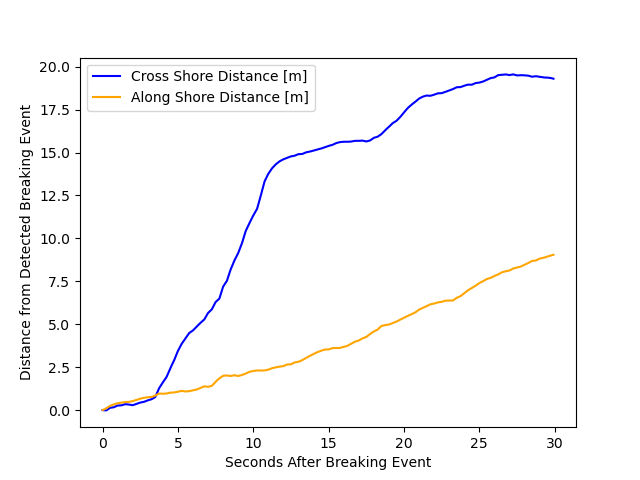

In [8]:
# Compute the average after breaking event profile 
cross_shore_dist_after_breaking_array = np.array(cross_shore_dist_after_breaking)
along_shore_dist_after_breaking_array = np.array(along_shore_dist_after_breaking)

cross_shore_dist_after_breaking_avg = np.mean(cross_shore_dist_after_breaking_array, axis=0)
along_shore_dist_after_breaking_avg = np.mean(along_shore_dist_after_breaking_array, axis=0)

# Plot the average trajectory after a breaking event
fig, ax = plt.subplots()
ax.plot(seconds_after_event, cross_shore_dist_after_breaking_avg, color='b', label='Cross Shore Distance [m]')
ax.plot(seconds_after_event, along_shore_dist_after_breaking_avg, color='orange', label='Along Shore Distance [m]')
ax.set_xlabel('Seconds After Breaking Event')
ax.set_ylabel('Distance from Detected Breaking Event')
ax.legend()

In [9]:
def distance_formula(x, y):
    """
    Compute the distance between the start x and y location and each other location
    """
    return np.sqrt((x[0]-x)**2 + (y[0]-y)**2)

Text(0, 0.5, 'Distance from Detected Breaking Event')

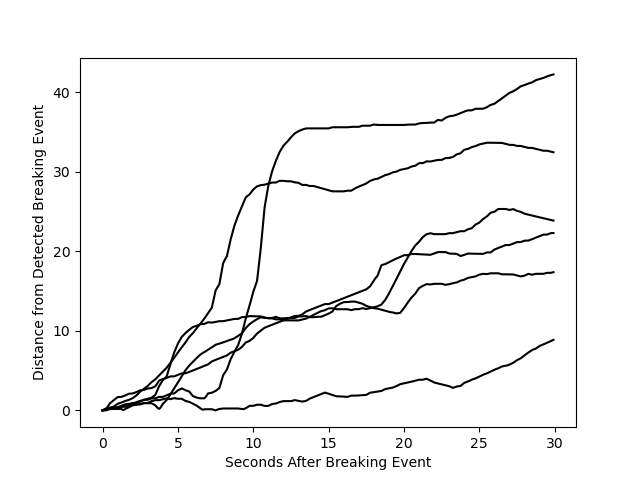

In [10]:
# Compute the total distance traveled by the buoys after each event
total_distance_from_start_after_breaking = []
for n in range(cross_shore_dist_after_breaking_array.shape[0]):
    total_distance_from_start_after_breaking.append(distance_formula(cross_shore_dist_after_breaking_array[n,:], along_shore_dist_after_breaking_array[n,:]))

total_distance_from_start_after_breaking = np.array(total_distance_from_start_after_breaking)

# Plot the total distance after breaking profiles
fig, ax = plt.subplots()
for n in range(total_distance_from_start_after_breaking.shape[0]):
    ax.plot(seconds_after_event, total_distance_from_start_after_breaking[n,:], color='k')

ax.set_xlabel('Seconds After Breaking Event')
ax.set_ylabel('Distance from Detected Breaking Event')

Text(0, 0.5, 'Distance from Detected Breaking Event')

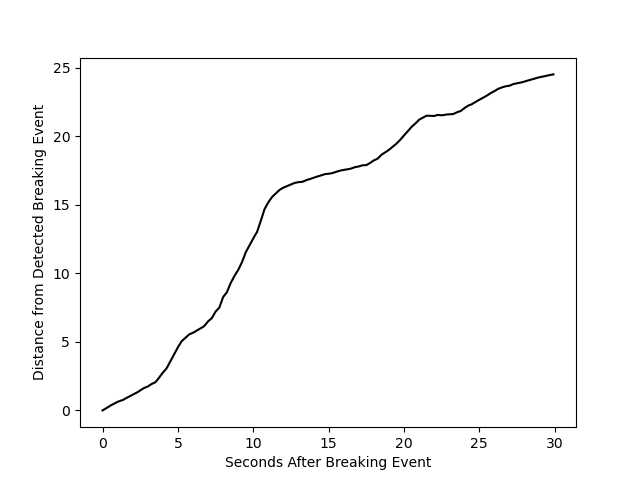

In [11]:
# Average Profile of total distance after breaking event
total_distance_from_start_after_breaking_avg = np.mean(total_distance_from_start_after_breaking, axis=0)

fig, ax = plt.subplots()
ax.plot(seconds_after_event, total_distance_from_start_after_breaking_avg, color='k')
ax.set_xlabel('Seconds After Breaking Event')
ax.set_ylabel('Distance from Detected Breaking Event')

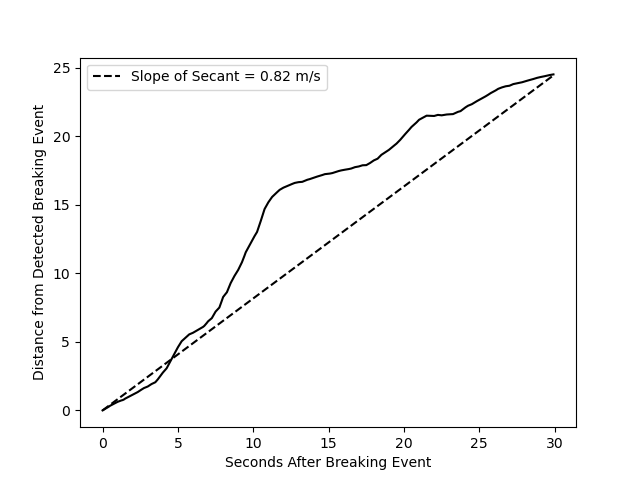

In [12]:
# Add average slope to the profile 
average_slope_of_total_distance = (total_distance_from_start_after_breaking_avg[-1] - total_distance_from_start_after_breaking_avg[0])/30

fig, ax = plt.subplots()
ax.plot(seconds_after_event, total_distance_from_start_after_breaking_avg, color='k')
ax.plot(seconds_after_event, seconds_after_event*average_slope_of_total_distance, color='k', linestyle='dashed', label=f'Slope of Secant = {np.round(average_slope_of_total_distance, 2)} m/s')
ax.set_xlabel('Seconds After Breaking Event')
ax.set_ylabel('Distance from Detected Breaking Event')
ax.legend()

## Expand this analysis to all buoys on this mission

In [13]:

time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)
x_locations = np.ma.masked_invalid(mission_dataset['xFRF']).filled(np.nan)
y_locations = np.ma.masked_invalid(mission_dataset['yFRF']).filled(np.nan)

# Save profiles after breaking event
cross_shore_dist_after_breaking = []
along_shore_dist_after_breaking = []

# Get list of trajectory numbers
trajectory_nums = breaker_df_mission19['trajectory number'].unique()
for trajectory_num in range(len(trajectory_nums)):
    # Convert times to actual datetimes
    breaking_events_trajectory_df = breaker_df_mission19[breaker_df_mission19['trajectory number'] == trajectory_num]
    breaking_events_trajectory_df['time'] = pd.to_datetime(breaking_events_trajectory_df['time'])
    breaking_event_times = breaking_events_trajectory_df['time'].tolist()

    trajectory_df = pd.DataFrame(np.transpose(np.array([time, x_locations[trajectory_num,:], y_locations[trajectory_num,:]])), columns=['time', 'cross shore location', 'along shore location'])

    for n in range(len(breaking_event_times)):  
        after_breaking_event_df = trajectory_df[trajectory_df.time.between(breaking_event_times[n].to_pydatetime(), breaking_event_times[n].to_pydatetime()+timedelta(seconds=30))]
        seconds_after_event = np.arange(len(after_breaking_event_df.index))/12

        # Save the after breaking event
        cross_shore_dist_after_breaking.append((after_breaking_event_df['cross shore location'].iloc[0] - after_breaking_event_df['cross shore location']).to_list())
        along_shore_dist_after_breaking.append((after_breaking_event_df['along shore location'].iloc[0] - after_breaking_event_df['along shore location']).to_list())

cross_shore_dist_after_breaking_array = np.array(cross_shore_dist_after_breaking)
along_shore_dist_after_breaking_array = np.array(along_shore_dist_after_breaking)

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/2996638091.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breaking_events_trajectory_df['time'] = pd.to_datetime(breaking_events_trajectory_df['time'])
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/2996638091.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breaking_events_trajectory_df['time'] = pd.to_datetime(breaking_events_trajectory_df['time'])
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/2

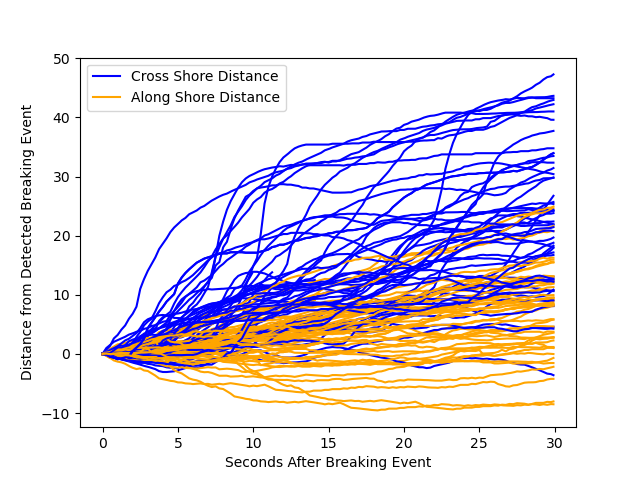

In [14]:
# Plot all trajectories 
fig, ax = plt.subplots()
for n in range(cross_shore_dist_after_breaking_array.shape[0]):
    ax.plot(seconds_after_event, cross_shore_dist_after_breaking_array[n,:], color='b')
    ax.plot(seconds_after_event, along_shore_dist_after_breaking_array[n,:], color='orange')

ax.plot(seconds_after_event, cross_shore_dist_after_breaking_array[n,:], color='b', label='Cross Shore Distance')
ax.plot(seconds_after_event, along_shore_dist_after_breaking_array[n,:], color='orange', label='Along Shore Distance')
ax.set_xlabel('Seconds After Breaking Event')
ax.set_ylabel('Distance from Detected Breaking Event')
ax.legend()

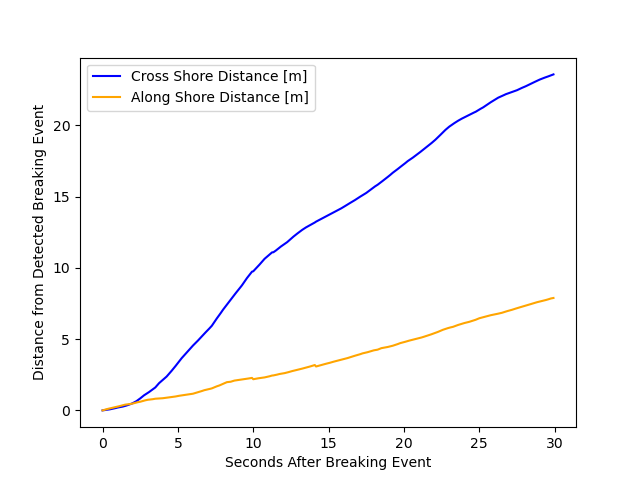

In [15]:
# Compute the average after breaking event profile 
cross_shore_dist_after_breaking_avg = np.nanmean(cross_shore_dist_after_breaking_array, axis=0)
along_shore_dist_after_breaking_avg = np.nanmean(along_shore_dist_after_breaking_array, axis=0)

# Plot the average trajectory after a breaking event
fig, ax = plt.subplots()
ax.plot(seconds_after_event, cross_shore_dist_after_breaking_avg, color='b', label='Cross Shore Distance [m]')
ax.plot(seconds_after_event, along_shore_dist_after_breaking_avg, color='orange', label='Along Shore Distance [m]')
ax.set_xlabel('Seconds After Breaking Event')
ax.set_ylabel('Distance from Detected Breaking Event')
ax.legend()

Text(0, 0.5, 'Distance from Detected Breaking Event')

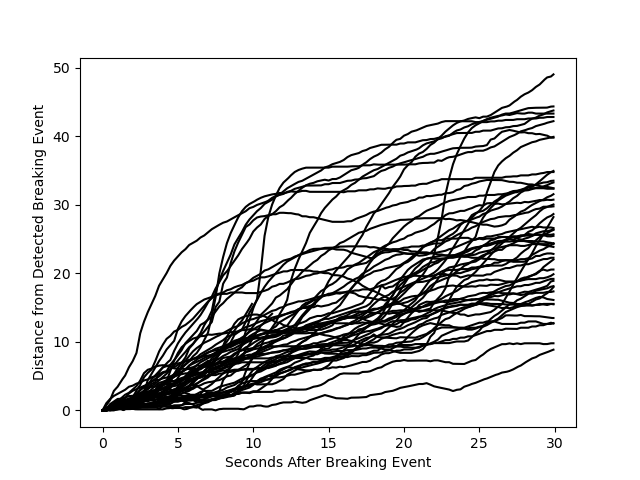

In [16]:
# Compute the total distance traveled by the buoys after each event
total_distance_from_start_after_breaking = []
for n in range(cross_shore_dist_after_breaking_array.shape[0]):
    total_distance_from_start_after_breaking.append(distance_formula(cross_shore_dist_after_breaking_array[n,:], along_shore_dist_after_breaking_array[n,:]))

total_distance_from_start_after_breaking = np.array(total_distance_from_start_after_breaking)

# Plot the total distance after breaking profiles
fig, ax = plt.subplots()
for n in range(total_distance_from_start_after_breaking.shape[0]):
    ax.plot(seconds_after_event, total_distance_from_start_after_breaking[n,:], color='k')

ax.set_xlabel('Seconds After Breaking Event')
ax.set_ylabel('Distance from Detected Breaking Event')

Text(0, 0.5, 'Distance from Detected Breaking Event')

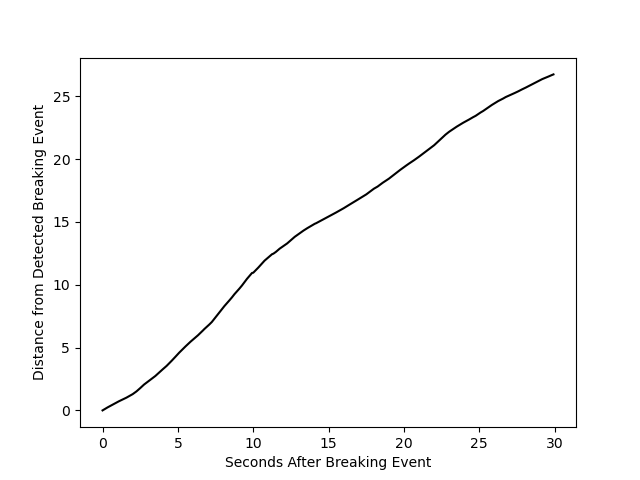

In [17]:
# Average Profile of total distance after breaking event
total_distance_from_start_after_breaking_avg = np.nanmean(total_distance_from_start_after_breaking, axis=0)

fig, ax = plt.subplots()
ax.plot(seconds_after_event, total_distance_from_start_after_breaking_avg, color='k')
ax.set_xlabel('Seconds After Breaking Event')
ax.set_ylabel('Distance from Detected Breaking Event')

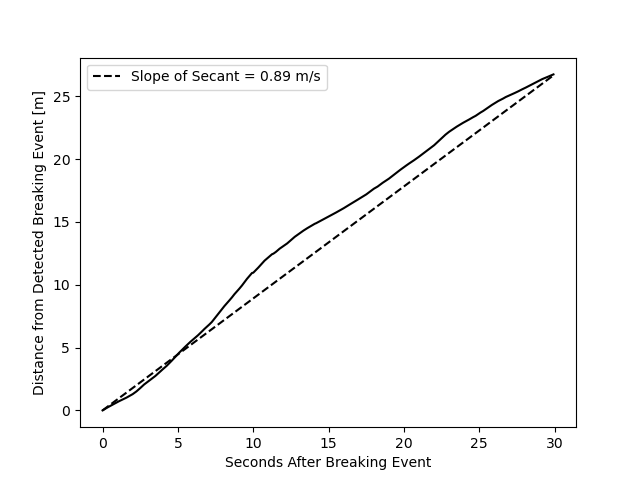

In [18]:
# Add average slope to the profile 
average_slope_of_total_distance = (total_distance_from_start_after_breaking_avg[-1] - total_distance_from_start_after_breaking_avg[0])/30

fig, ax = plt.subplots()
ax.plot(seconds_after_event, total_distance_from_start_after_breaking_avg, color='k')
ax.plot(seconds_after_event, seconds_after_event*average_slope_of_total_distance, color='k', linestyle='dashed', label=f'Slope of Secant = {np.round(average_slope_of_total_distance, 2)} m/s')
ax.set_xlabel('Seconds After Breaking Event')
ax.set_ylabel('Distance from Detected Breaking Event [m]')
ax.legend()

## Go back and look at the accelerations and the breaking event and do a deeper dive

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/2354083154.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/2354083154.py:18: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.g

(18908.77766203704, 18908.778125)

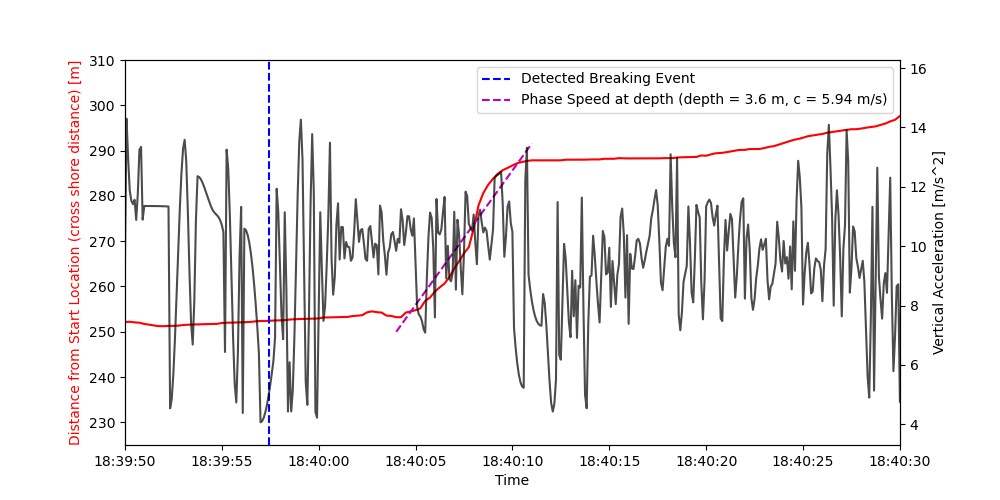

In [66]:
# Plot the time series of cross shore and along shore location with the breaking events
trajectory_num = 5
example_trajectory_df = breaker_df_mission19[breaker_df_mission19['trajectory number'] == trajectory_num]

time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)

# Convert times to actual datetimes
example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
breaking_event_times = example_trajectory_df['time'].tolist()

# breaking event depth
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)
bathy = bathy_dataset['elevation'][0,:,:]
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy_f = interpolate.interp2d(xFRF_grid, yFRF_grid, bathy)
breaking_depth = bathy_f(example_trajectory_df['cross shore location [m]'].iloc[0],
                          example_trajectory_df['along shore location [m]'].iloc[0]).item()

# phase speed for breaking 
c_breaking = np.sqrt(9.8 * np.abs(breaking_depth)) 
seconds_phase_speed = np.linspace(0, 7, 15)
distance_traveled_at_phase_speed = (c_breaking * seconds_phase_speed) + 250 # offset for fitting to the plot
t = pd.date_range(start='2021-10-08T18:40:04',
                  end='2021-10-08T18:40:11',
                  periods=15)


fig, ax1 = plt.subplots(figsize=(10,5))

# Cross Shore Distance
ax1.plot(time, x_locations[trajectory_num,0] - x_locations[trajectory_num,:], color='r')
ax1.axvline(breaking_event_times[0], color='b', label='Detected Breaking Event', linestyle='dashed')
ax1.plot(t.values, distance_traveled_at_phase_speed, color='m', linestyle='dashed', 
         label=f'Phase Speed at depth (depth = {np.round(np.abs(breaking_depth), 2)} m, c = {np.round(c_breaking, 2)} m/s)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance from Start Location (cross shore distance) [m]', color='r')
ax1.set_ylim(225, 310)

# Vertical Acceleration
ax2 = ax1.twinx()
ax2.plot(time, vertical_accel[trajectory_num], label='Vertical Acceleration (body frame)', color='k', alpha=0.7)
ax2.set_ylabel('Vertical Acceleration [m/s^2]')

ax1.legend()
ax1.set_xlim(datetime(2021, 10, 8, 18, 39, 50), datetime(2021, 10, 8, 18, 40, 30))



## What do detected breaking events look like when there isnt a jump

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/2540104939.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(18908.78009259259, 18908.781365740742)

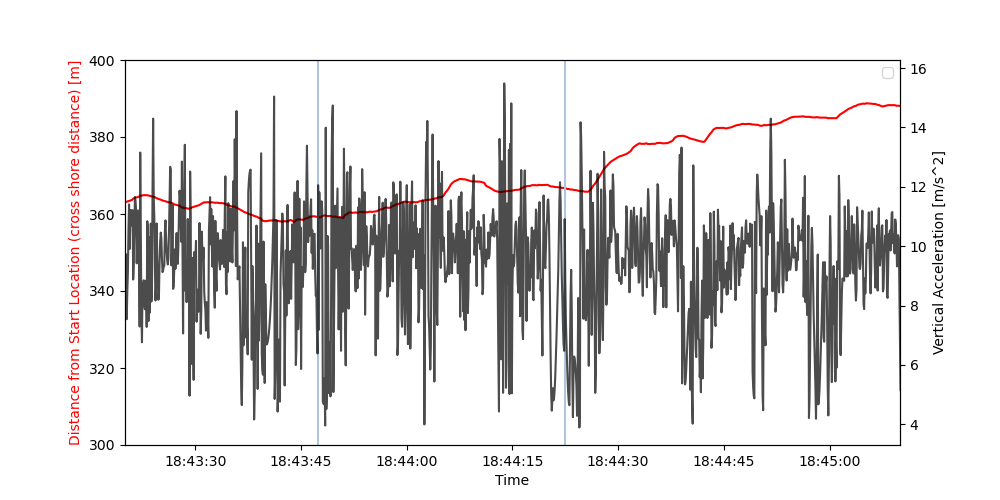

In [76]:
# Plot the time series of cross shore and along shore location with the breaking events
trajectory_num = 5
example_trajectory_df = breaker_df_mission19[breaker_df_mission19['trajectory number'] == trajectory_num]

time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)

# Convert times to actual datetimes
example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
breaking_event_times = example_trajectory_df['time'].tolist()

fig, ax1 = plt.subplots(figsize=(10,5))

# Cross Shore Distance
ax1.plot(time, x_locations[trajectory_num,0] - x_locations[trajectory_num,:], color='r')
for n in range(len(breaking_event_times)):
    ax1.axvline(breaking_event_times[n], color='lightsteelblue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance from Start Location (cross shore distance) [m]', color='r')
ax1.set_ylim(300, 400)

# Vertical Acceleration
ax2 = ax1.twinx()
ax2.plot(time, vertical_accel[trajectory_num], label='Vertical Acceleration (body frame)', color='k', alpha=0.7)
ax2.set_ylabel('Vertical Acceleration [m/s^2]')

ax1.legend()
ax1.set_xlim(datetime(2021, 10, 8, 18, 43, 20), datetime(2021, 10, 8, 18, 45, 10))

## How to detect just these individual jump events to get the jump amplitude and timescales

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/2097043833.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/2097043833.py:18: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.g

(18908.77766203704, 18908.778125)

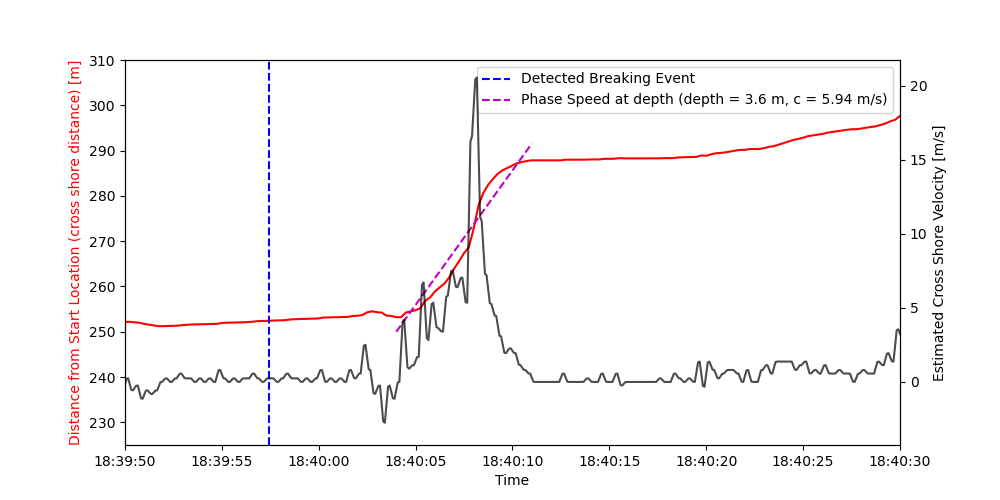

In [103]:
# Plot the time series of cross shore and along shore location with the breaking events
trajectory_num = 5
example_trajectory_df = breaker_df_mission19[breaker_df_mission19['trajectory number'] == trajectory_num]

time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)

# Convert times to actual datetimes
example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
breaking_event_times = example_trajectory_df['time'].tolist()

# breaking event depth
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)
bathy = bathy_dataset['elevation'][0,:,:]
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy_f = interpolate.interp2d(xFRF_grid, yFRF_grid, bathy)
breaking_depth = bathy_f(example_trajectory_df['cross shore location [m]'].iloc[0],
                          example_trajectory_df['along shore location [m]'].iloc[0]).item()

# phase speed for breaking 
c_breaking = np.sqrt(9.8 * np.abs(breaking_depth)) 
seconds_phase_speed = np.linspace(0, 7, 15)
distance_traveled_at_phase_speed = (c_breaking * seconds_phase_speed) + 250 # offset for fitting to the plot
t = pd.date_range(start='2021-10-08T18:40:04',
                  end='2021-10-08T18:40:11',
                  periods=15)

# Compute Cross Shore Velocity 
cross_shore_vel = np.gradient((x_locations[trajectory_num,0] - x_locations[trajectory_num,:]), 1/12)
cross_shore_accel = np.gradient(cross_shore_vel, 1/12)

fig, ax1 = plt.subplots(figsize=(10,5))

# Cross Shore Distance
ax1.plot(time, x_locations[trajectory_num,0] - x_locations[trajectory_num,:], color='r')
ax1.axvline(breaking_event_times[0], color='b', label='Detected Breaking Event', linestyle='dashed')
ax1.plot(t.values, distance_traveled_at_phase_speed, color='m', linestyle='dashed', 
         label=f'Phase Speed at depth (depth = {np.round(np.abs(breaking_depth), 2)} m, c = {np.round(c_breaking, 2)} m/s)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance from Start Location (cross shore distance) [m]', color='r')
ax1.set_ylim(225, 310)

# Cross Shore Velocity
ax2 = ax1.twinx()
ax2.plot(time, cross_shore_vel, label='Cross Shore Velocity Estimate', color='k', alpha=0.7)
ax2.set_ylabel('Estimated Cross Shore Velocity [m/s]')

ax1.legend()
# ax2.legend()
# ax3.legend()
ax1.set_xlim(datetime(2021, 10, 8, 18, 39, 50), datetime(2021, 10, 8, 18, 40, 30))

Apply a low pass filter to the cross shore velocity to pick out the surfing events


(18908.77766203704, 18908.778125)

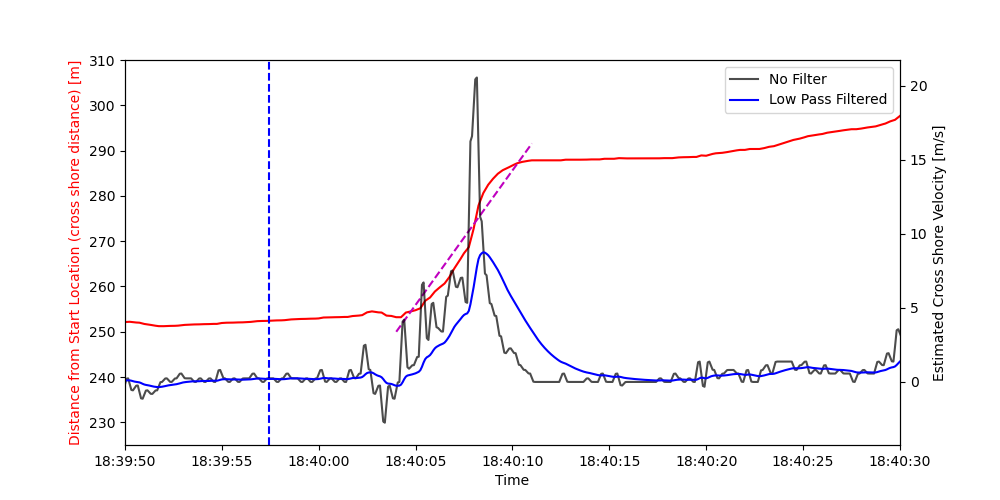

In [118]:
# Apply low pass filter to velocity 
cross_shore_vel = np.ma.filled(cross_shore_vel, np.NaN)
sos = signal.butter(1, 0.1, 'lowpass', fs=12, output='sos')
cross_shore_vel_filtered = signal.sosfilt(sos, cross_shore_vel)

fig, ax1 = plt.subplots(figsize=(10,5))

# Cross Shore Distance
ax1.plot(time, x_locations[trajectory_num,0] - x_locations[trajectory_num,:], color='r')
ax1.axvline(breaking_event_times[0], color='b', label='Detected Breaking Event', linestyle='dashed')
ax1.plot(t.values, distance_traveled_at_phase_speed, color='m', linestyle='dashed', 
         label=f'Phase Speed at depth (depth = {np.round(np.abs(breaking_depth), 2)} m, c = {np.round(c_breaking, 2)} m/s)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance from Start Location (cross shore distance) [m]', color='r')
ax1.set_ylim(225, 310)

# Cross Shore Velocity
ax2 = ax1.twinx()
ax2.plot(time, cross_shore_vel, label='No Filter', color='k', alpha=0.7)
ax2.plot(time, cross_shore_vel_filtered, label='Low Pass Filtered', color='b')
ax2.set_ylabel('Estimated Cross Shore Velocity [m/s]')

# ax1.legend()
ax2.legend()
# ax3.legend()
ax1.set_xlim(datetime(2021, 10, 8, 18, 39, 50), datetime(2021, 10, 8, 18, 40, 30))

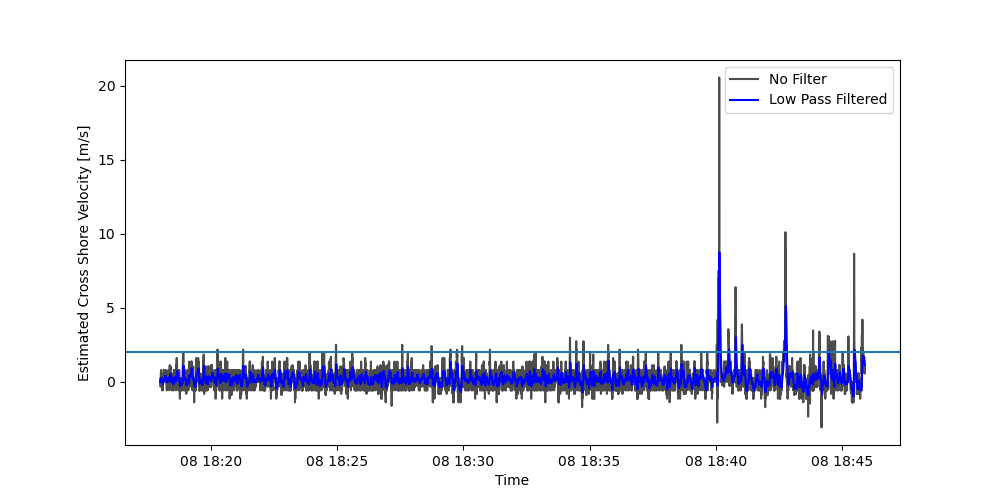

In [121]:
fig, ax1 = plt.subplots(figsize=(10,5))

# Cross Shore Distance
ax1.plot(time, cross_shore_vel, label='No Filter', color='k', alpha=0.7)
ax1.plot(time, cross_shore_vel_filtered, label='Low Pass Filtered', color='b')
ax1.axhline(2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Estimated Cross Shore Velocity [m/s]')
ax1.legend()

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/66901289.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/66901289.py:18: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.githu

(18908.77766203704, 18908.778125)

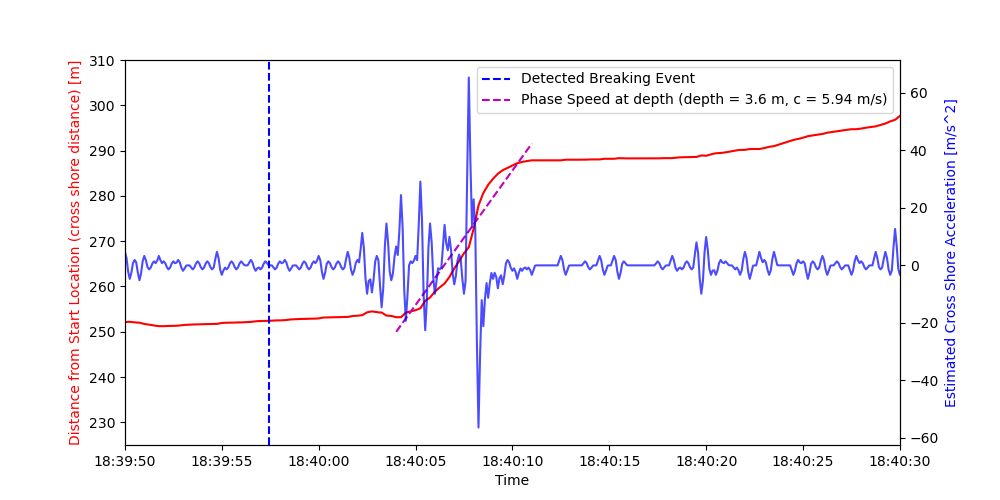

In [93]:
# Plot the time series of cross shore and along shore location with the breaking events
trajectory_num = 5
example_trajectory_df = breaker_df_mission19[breaker_df_mission19['trajectory number'] == trajectory_num]

time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)

# Convert times to actual datetimes
example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
breaking_event_times = example_trajectory_df['time'].tolist()

# breaking event depth
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)
bathy = bathy_dataset['elevation'][0,:,:]
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy_f = interpolate.interp2d(xFRF_grid, yFRF_grid, bathy)
breaking_depth = bathy_f(example_trajectory_df['cross shore location [m]'].iloc[0],
                          example_trajectory_df['along shore location [m]'].iloc[0]).item()

# phase speed for breaking 
c_breaking = np.sqrt(9.8 * np.abs(breaking_depth)) 
seconds_phase_speed = np.linspace(0, 7, 15)
distance_traveled_at_phase_speed = (c_breaking * seconds_phase_speed) + 250 # offset for fitting to the plot
t = pd.date_range(start='2021-10-08T18:40:04',
                  end='2021-10-08T18:40:11',
                  periods=15)

# Compute Cross Shore Velocity 
cross_shore_vel = np.gradient((x_locations[trajectory_num,0] - x_locations[trajectory_num,:]), 1/12)
cross_shore_accel = np.gradient(cross_shore_vel, 1/12)

fig, ax1 = plt.subplots(figsize=(10,5))

# Cross Shore Distance
ax1.plot(time, x_locations[trajectory_num,0] - x_locations[trajectory_num,:], color='r')
ax1.axvline(breaking_event_times[0], color='b', label='Detected Breaking Event', linestyle='dashed')
ax1.plot(t.values, distance_traveled_at_phase_speed, color='m', linestyle='dashed', 
         label=f'Phase Speed at depth (depth = {np.round(np.abs(breaking_depth), 2)} m, c = {np.round(c_breaking, 2)} m/s)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance from Start Location (cross shore distance) [m]', color='r')
ax1.set_ylim(225, 310)

# Cross Shore Acceleration Estimate
ax2 = ax1.twinx()
ax2.plot(time, cross_shore_accel, label='Cross Shore Velocity Estimate', color='b', alpha=0.7)
ax2.set_ylabel('Estimated Cross Shore Acceleration [m/s^2]', color='b')

ax1.legend()
# ax2.legend()
# ax3.legend()
ax1.set_xlim(datetime(2021, 10, 8, 18, 39, 50), datetime(2021, 10, 8, 18, 40, 30))



/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/1437013486.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_18543/1437013486.py:18: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.g

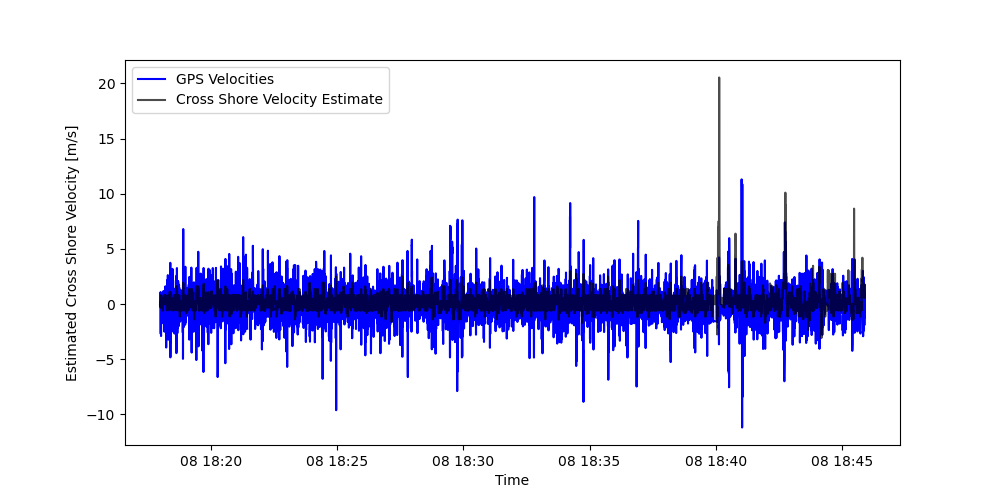

In [100]:
# Plot the time series of cross shore and along shore location with the breaking events
trajectory_num = 5
example_trajectory_df = breaker_df_mission19[breaker_df_mission19['trajectory number'] == trajectory_num]

time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)

# Convert times to actual datetimes
example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
breaking_event_times = example_trajectory_df['time'].tolist()

# breaking event depth
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)
bathy = bathy_dataset['elevation'][0,:,:]
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy_f = interpolate.interp2d(xFRF_grid, yFRF_grid, bathy)
breaking_depth = bathy_f(example_trajectory_df['cross shore location [m]'].iloc[0],
                          example_trajectory_df['along shore location [m]'].iloc[0]).item()

# phase speed for breaking 
c_breaking = np.sqrt(9.8 * np.abs(breaking_depth)) 
seconds_phase_speed = np.linspace(0, 7, 15)
distance_traveled_at_phase_speed = (c_breaking * seconds_phase_speed) + 250 # offset for fitting to the plot
t = pd.date_range(start='2021-10-08T18:40:04',
                  end='2021-10-08T18:40:11',
                  periods=15)

# Compute Cross Shore Velocity 
cross_shore_vel = np.gradient((x_locations[trajectory_num,0] - x_locations[trajectory_num,:]), 1/12)
cross_shore_accel = np.gradient(cross_shore_vel, 1/12)

fig, ax1 = plt.subplots(figsize=(10,5))

# Cross Shore Distance
# Cross Shore Velocity
ax1.plot(time, velocity_ew[trajectory_num,:], label='GPS Velocities', color='b')
ax1.plot(time, cross_shore_vel, label='Cross Shore Velocity Estimate', color='k', alpha=0.7)
ax1.set_ylabel('Estimated Cross Shore Velocity [m/s]')
ax1.set_xlabel('Time')



ax1.legend()
# ax2.legend()
# ax3.legend()
# ax1.set_xlim(datetime(2021, 10, 8, 18, 39, 50), datetime(2021, 10, 8, 18, 40, 30))